# Entity Discovery and Linking 2019

## Understanding the data

In [1137]:
import pandas as pd
import operator
import collections
import matplotlib.pyplot as plt
from collections import Counter
from nltk import word_tokenize
from sklearn.model_selection import train_test_split

In [1145]:
#useful method to understund the data

def parse_data(data_path):
    df_data=pd.read_csv(data_path, delimiter='\t', header=None)
    df_data=df_data.set_axis(['start', 'end', 'sentence','mention_type','information'], axis=1, inplace=False)
    
    #extract the named entity using the two feature 'end' and 'start' 
    m=[]
    for i in df_data.index:
        l=df_data.loc[i]
        sent=word_tokenize(l.sentence)
        s=''
    #     print(i)
        for j in range(int(l.end)-int(l.start)):
            s+=sent[j+int(l[0])]+' '
             #in some cases we get a wrong end which lead us to an index out of range error 
#             if j+int(l[0])<len(sent):
#                 s+=sent[j+int(l[0])]+' '

        m.append(s)
    
    df_data['entity']=m
    #transform mention types to a list of mentions
    df_data.mention_type=df_data.mention_type.apply(lambda x: x.split())
#     df_data.sentence=df_data.sentence.apply(lambda x : '<PAD> '+x+' <PAD>')
    return df_data

def different_mentions(df_data):    
    lst=[]
    for i in df_data.index:
        lst+=df_data.mention_type[i]
    diff_mentions=set( lst)
    return diff_mentions,lst

def plot_distribution(data_mention,mention_name):
    
    d1 = dict(data_mention.items())
    plt.figure(figsize=(15,5))
    plt.xticks(rotation=90)
    plt.title('distribution of {} mentions type'.format(mention_name))
    plt.bar(*zip(*d1.items()))
    plt.show()

In [1139]:
len(df_ontonotes_dev.loc[1940].sentence.split())

31

In [172]:
df_ontonotes_dev.loc[1940]

start                                                          27
end                                                            35
sentence        The Bush administration , trying to blunt grow...
mention_type                  /organization /organization/company
information     HEAD|Ing NON_HEAD|Italy NON_HEAD|'s NON_HEAD|....
Name: 1940, dtype: object

this example can lead to error, as you can see the length of the sentence is 31 and the 'end' feature equal to 35, so, in order to avoid this issue, i add a condition that verify if the index is less than the length of the sentence 

In [1142]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/aaloui/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [1151]:
#read all the data

df_ontonotes_train=parse_data('OntoNotes/train.txt')
df_ontonotes_test=parse_data('OntoNotes/test.txt')
df_ontonotes_dev=parse_data('OntoNotes/dev.txt')
#df_wiki_train=parse_data('Wiki/train.txt')
#df_wiki_test=parse_data('Wiki/test.txt')
#df_wiki_dev=parse_data('Wiki/dev.txt')

In [1169]:
df_ontonotes_train.loc[60]['sentence']

'Because after the Wannan Incident Ye Zhengming and his father Ye Ting were imprisoned for two years in a Kuomnintang prison .'

In [ ]:
df_ontonotes_all=parse_data('OntoNotes/all.txt')
df_wiki_all=parse_data('Wiki/all.txt')

# ontonotes training data

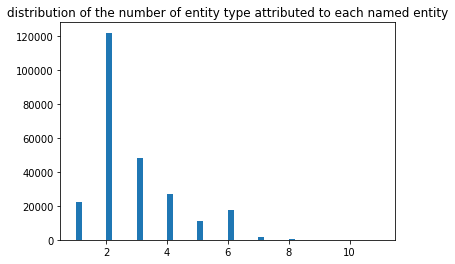

In [194]:
df_num_entity=[len(df_ontonotes_train.loc[i].mention_type) for i in df_ontonotes_train.index]
plt.title('distribution of the number of entity type attributed to each named entity')
plt.hist(df_num_entity,bins=50);


-one entity can be attributed with many mention type.<br>
-the data was generated by **distant supervision**,  In distant supervision, we make use of an already existing database, such as Freebase or a domain-specific database, to collect examples for the relation we want to extract. We then use these examples to automatically generate our training data. so, it's natural to get more than one mention type were attributed to one entity.<br>
**Problem:** <br>
-which is the most correct mention type that i should consider for training the model?


In [219]:
diff_mentions,ls_mentions=different_mentions(df_ontonotes_train)
diff_mentions

{'/location',
 '/location/celestial',
 '/location/city',
 '/location/country',
 '/location/geography',
 '/location/geography/body_of_water',
 '/location/geography/island',
 '/location/geography/mountain',
 '/location/geograpy',
 '/location/geograpy/island',
 '/location/park',
 '/location/structure',
 '/location/structure/airport',
 '/location/structure/government',
 '/location/structure/hospital',
 '/location/structure/hotel',
 '/location/structure/restaurant',
 '/location/structure/sports_facility',
 '/location/structure/theater',
 '/location/transit',
 '/location/transit/bridge',
 '/location/transit/railway',
 '/location/transit/road',
 '/organization',
 '/organization/company',
 '/organization/company/broadcast',
 '/organization/company/news',
 '/organization/education',
 '/organization/government',
 '/organization/military',
 '/organization/music',
 '/organization/political_party',
 '/organization/sports_league',
 '/organization/sports_team',
 '/organization/stock_exchange',
 '/org

In [202]:
len(diff_mentions)

89

-here the problem not a traditional multi-class classification, but we deal here with a hierarchical classes<br>
-the maximum depth of a mention type is 3<br>
-we have 89 different mentions type for the ontonotes training data<br>
-for the first level we have 4 mentions types:
<li>person</li>
<li>other </li>
<li>organization</li>
<li>location</li>


In [271]:
occ_mentions=Counter(ls_mentions)
occ_mentions=dict(occ_mentions)
other_mention = {x: occ_mentions[x] for x in occ_mentions if x[:6]=='/other'}
person_mention = {x: occ_mentions[x] for x in occ_mentions if x[:7]=='/person'}
organization_mention = {x: occ_mentions[x] for x in occ_mentions if x[:13]=='/organization'}
location_mention = {x: occ_mentions[x] for x in occ_mentions if x[:9]=='/location'}

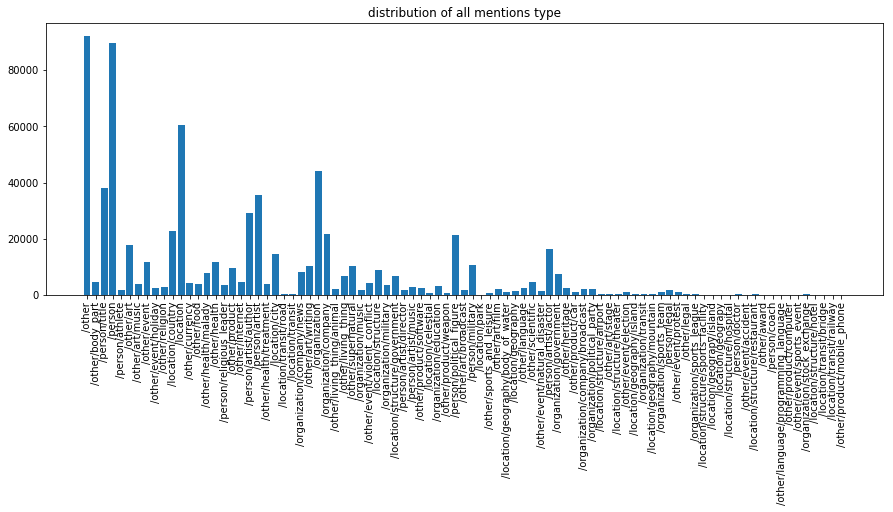

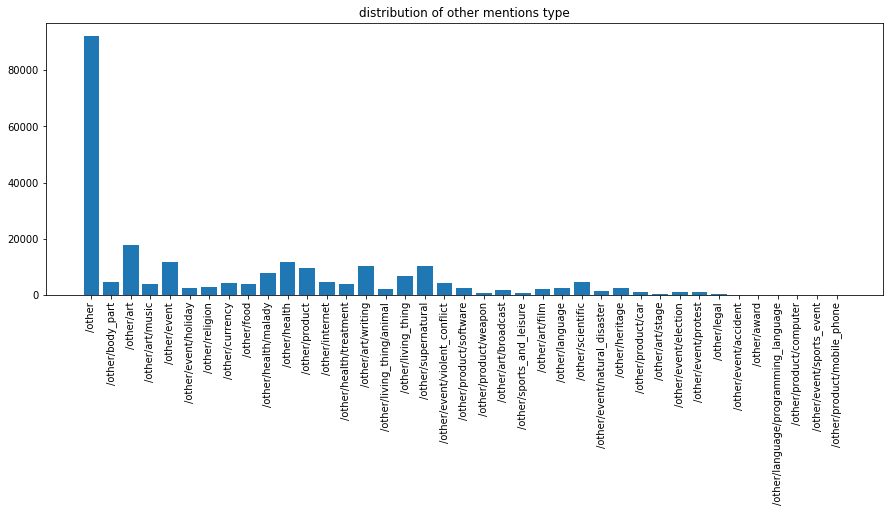

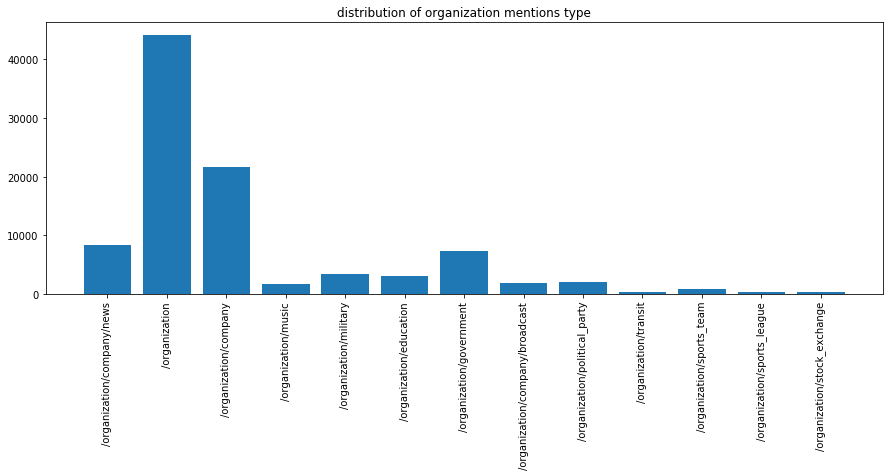

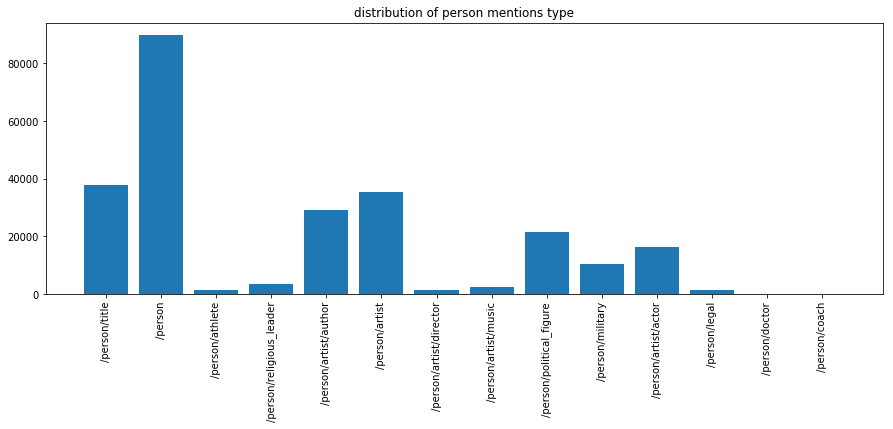

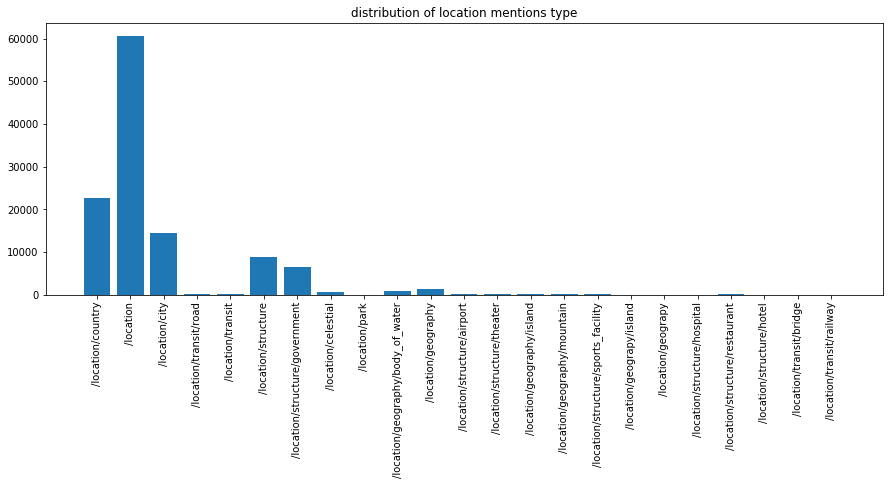

In [315]:
plot_distribution(occ_mentions,'all'), plot_distribution(other_mention,'other'), plot_distribution(organization_mention,'organization'),plot_distribution(person_mention,'person'),plot_distribution(location_mention,'location');

here we're facing to a very imbalanced classes,where there are a disproportionate ratio of observations in each class. this can easily leads our model to **overfitting** if we deal with this problem as a standard multi-class classification.

# ontonotes test data

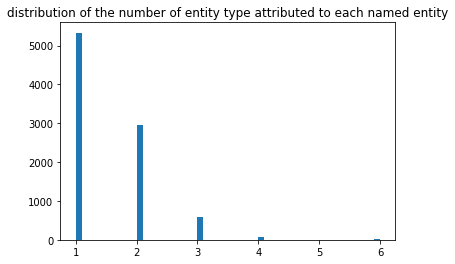

In [317]:
df_num_entity_test=[len(df_ontonotes_test.loc[i].mention_type) for i in df_ontonotes_test.index]
plt.title('distribution of the number of entity type attributed to each named entity')
plt.hist(df_num_entity_test,bins=50);


most of the entity named was attributed by a single or two mentions

In [319]:
diff_mentions_test,ls_mentions_test=different_mentions(df_ontonotes_test)
len(diff_mentions)

89

In [320]:
occ_mentions_test=Counter(ls_mentions_test)
occ_mentions_test=dict(occ_mentions_test)
other_mention_test = {x: occ_mentions_test[x] for x in occ_mentions_test if x[:6]=='/other'}
person_mention_test = {x: occ_mentions_test[x] for x in occ_mentions_test if x[:7]=='/person'}
organization_mention_test = {x: occ_mentions_test[x] for x in occ_mentions_test if x[:13]=='/organization'}
location_mention_test = {x: occ_mentions_test[x] for x in occ_mentions_test if x[:9]=='/location'}


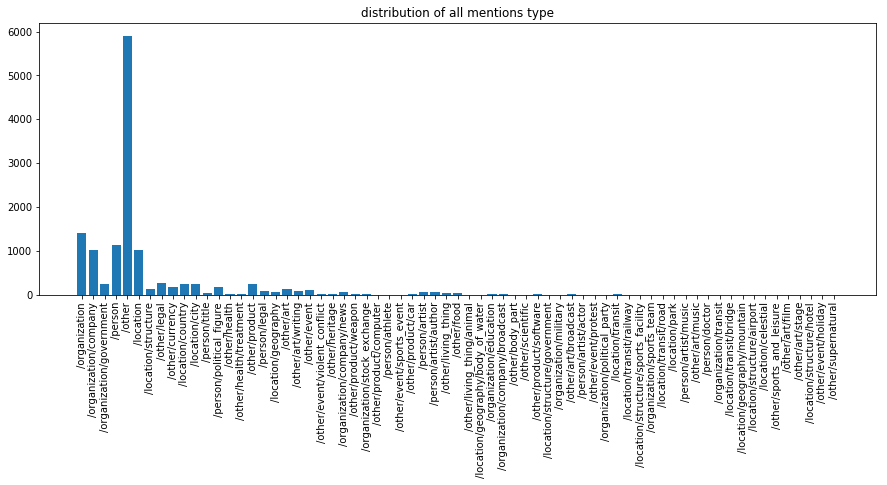

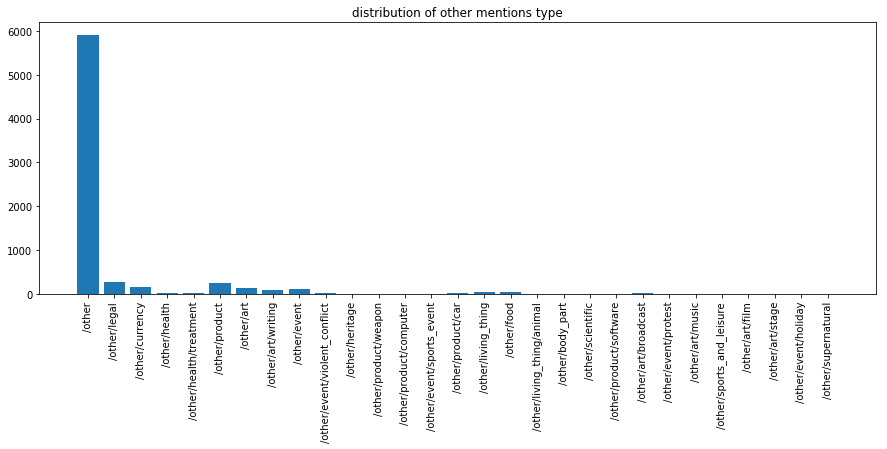

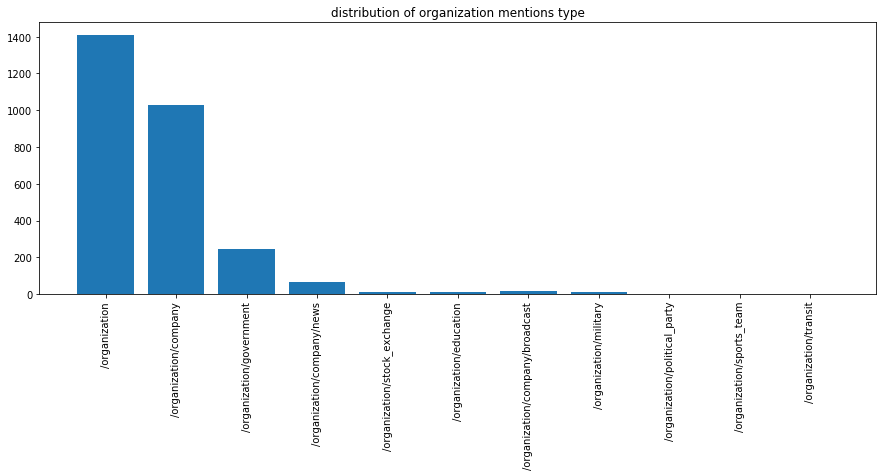

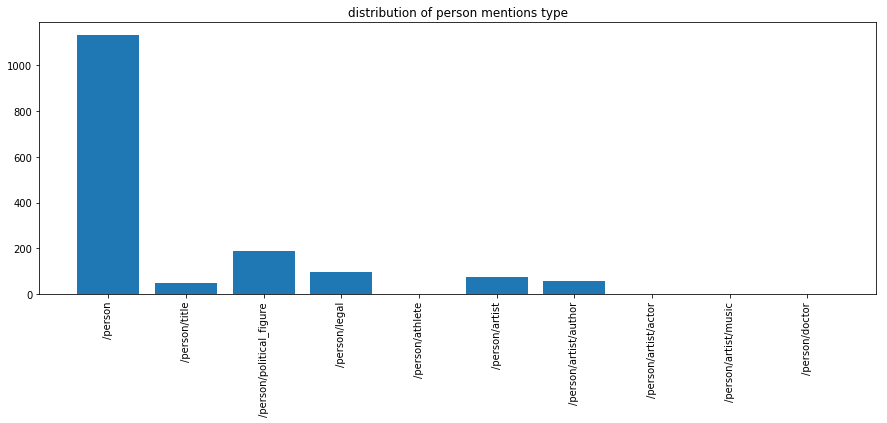

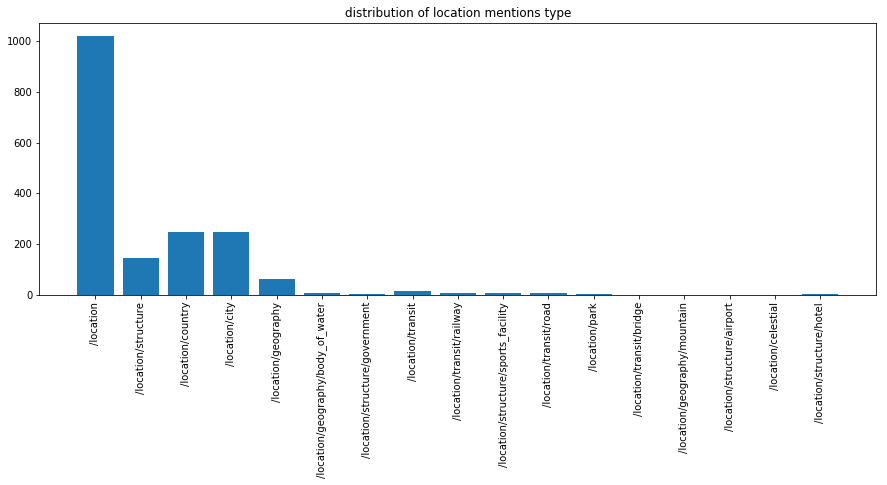

In [321]:
plot_distribution(occ_mentions_test,'all'), plot_distribution(other_mention_test,'other'), plot_distribution(organization_mention_test,'organization'),plot_distribution(person_mention_test,'person'),plot_distribution(location_mention_test,'location');

-roughly the same distribution as the training data<br>
-we have a very large of examples where the mention type is (**location or other or person or organization**) <br> 
-if we treat the problem as a standard multi-class classification, the model would be **biased** by those four classes

# Wiki training data

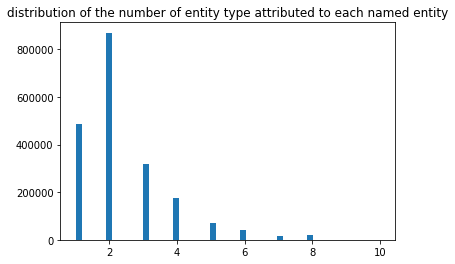

In [323]:
df_num_entity_w_train=[len(df_wiki_train.loc[i].mention_type) for i in df_wiki_train.index]
plt.title('distribution of the number of entity type attributed to each named entity')
plt.hist(df_num_entity_w_train,bins=50);

'Usually directors , otherwise , they have beards and very long hair , or otherwise they shave their heads .'

one entity can be attributed with many mention type.<br>

In [331]:
diff_mentions_w_train,ls_mentions_w_train=different_mentions(df_wiki_train)
diff_mentions_w_train

{'/art',
 '/art/film',
 '/astral_body',
 '/award',
 '/biology',
 '/body_part',
 '/broadcast',
 '/broadcast/tv_channel',
 '/broadcast_network',
 '/broadcast_program',
 '/building',
 '/building/airport',
 '/building/hospital',
 '/building/library',
 '/building/restaurant',
 '/building/sports_facility',
 '/building/theater',
 '/chemistry',
 '/computer',
 '/computer/programming_language',
 '/disease',
 '/education',
 '/education/department',
 '/education/educational_degree',
 '/event',
 '/event/attack',
 '/event/election',
 '/event/military_conflict',
 '/event/natural_disaster',
 '/event/protest',
 '/event/sports_event',
 '/finance',
 '/finance/currency',
 '/food',
 '/game',
 '/geography',
 '/geography/island',
 '/geography/mountain',
 '/god',
 '/government',
 '/government/government',
 '/government/political_party',
 '/government_agency',
 '/internet',
 '/internet/website',
 '/language',
 '/law',
 '/living_thing',
 '/livingthing',
 '/livingthing/animal',
 '/location',
 '/location/body_of_

In [332]:
len(diff_mentions_w_train)

113

-wiki data has more classes than the ontonotes data 113 against 89<br>
-wiki data has 43 classes for the first level against 4 in the ontonotes data<br> 
-the maximum depth of a mention type is 2<br>


In [335]:
occ_mentions_w_train=Counter(ls_mentions_w_train)
occ_mentions_w_train=dict(occ_mentions_w_train)
# other_mention_w_train = {x: occ_mentions_w_train[x] for x in occ_mentions_w_train if x[:6]=='/other'}
# person_mention_w_train = {x: occ_mentions_w_train[x] for x in occ_mentions_w_train if x[:7]=='/person'}
# organization_mention_w_train = {x: occ_mentions_w_train[x] for x in occ_mentions_w_train if x[:13]=='/organization'}
# location_mention_w_train = {x: occ_mentions_w_train[x] for x in occ_mentions_w_train if x[:9]=='/location'}


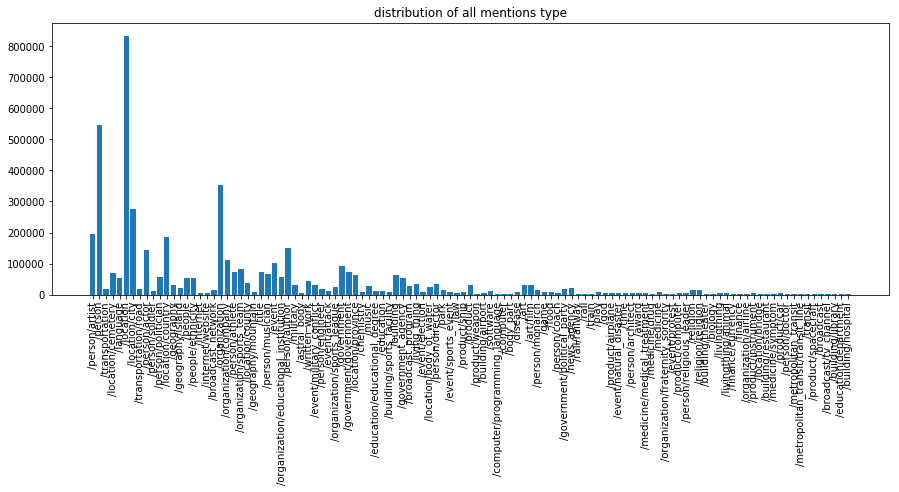

In [333]:
plot_distribution(occ_mentions_w_train,'all');

very imbalanced classes

In [357]:
df_ontonotes.loc[250355].mention_type

['/other',
 '/other/product/car',
 '/organization',
 '/organization/transit',
 '/other/product']

in some examples we get a noisy examples. as the example above: the entity is 'bus' , it is a car a subtype of a product , and transit a subtype of organization.

In [361]:
df_ontonotes.loc[44].mention_type

['/other',
 '/organization/company/news',
 '/other/art',
 '/other/art/writing',
 '/organization',
 '/organization/company']

another example for the article 'the', it is a company and an art 

In [ ]:
df_ontonotes_train=df_ontonotes_train.drop('information',axis=1)
# df_wiki_train=df_wiki_train.drop('information',axis=1)
df_ontonotes_test=df_ontonotes_test.drop('information',axis=1)
df_ontonotes_dev=df_ontonotes_dev.drop('information',axis=1)

In [ ]:
# keep the most significant mentions and remove the redundant mention
# example: /person /person/artist /person/artist/actor ==> /person/artist/actor""" 
def clear_mention(data):
    
    data=data.drop('information',axis=1)
    mention_type_column=[]
    mention_1_column=[]
    for i in data.index:
        out_type = []
        t=[]
        types=data.loc[i].mention_type
        for a in types:
            flag = True
            for b in types:
                if len(a) >= len(b):
                    continue
                if (a == b[:len(a)]) and (b[len(a)] == "/"):
                    flag = False
            if flag:
                out_type.append(a)
        mention_type_column.append(out_type)
        
        l1=[]

        for k in types:
            l1+=k.split('/')
        d=dict(Counter(l1))
        del d['']
        m=max(d.items(), key=operator.itemgetter(1))[0]
        ok=True
        for a in out_type:
            if (m == a[1:len(m)+1]) and (ok==True):
                ok=False
                t.append(a)
        mention_1_column.append(t)
                
                
    data['one_mention']=mention_1_column
    data['clear_mention']=mention_type_column
    return data

In [ ]:
df_ontonotes_train=clear_mention(df_ontonotes_train)
df_ontonotes_test=clear_mention(df_ontonotes_test)
df_ontonotes_dev=clear_mention(df_ontonotes_dev)

In [ ]:
df_ontonotes_dev.head()

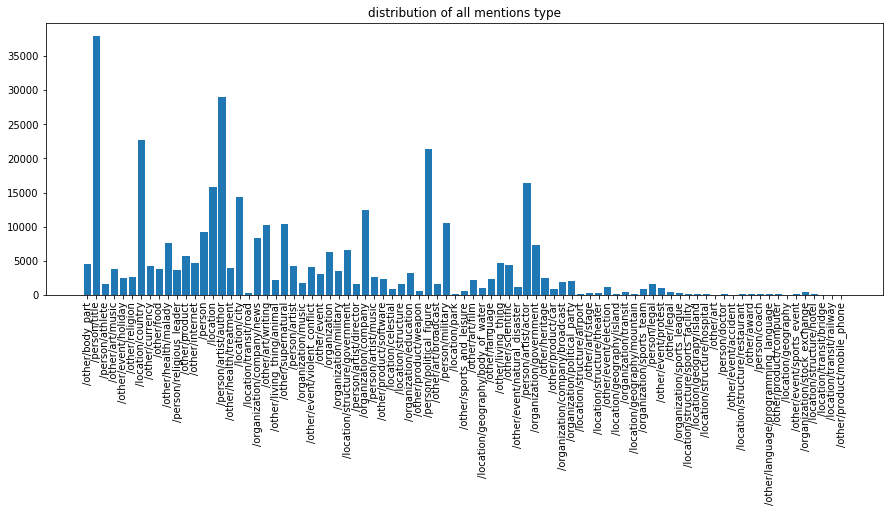

In [426]:
lst=[]
for i in df_ontonotes_train.index:
    lst+=df_ontonotes_train.one_mention[i]
diff_mentions_cl=set( lst)
occ_mentions_cl=Counter(lst)
occ_mentions_cl=dict(occ_mentions_cl)
plot_distribution(occ_mentions_cl,'all')

In [468]:
len(diff_mentions_cl)

85

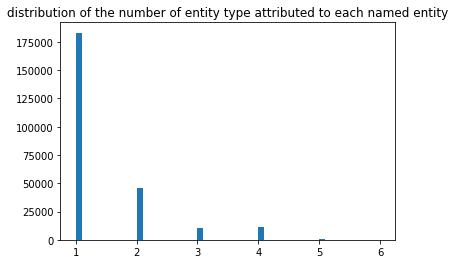

In [428]:
df_num_entity_cl=[len(df_ontonotes_train.loc[i].clear_mention) for i in df_ontonotes_train.index]
plt.title('distribution of the number of entity type attributed to each named entity')
plt.hist(df_num_entity_cl,bins=50);


In [488]:
def create_type_dict(typeSet):

    type2id = {y: x for x, y in enumerate(typeSet)}
    typeDict = collections.defaultdict(list)
    for a in type2id.keys():
        for b in type2id.keys():
            if len(a) >= len(b):
                continue
            if (a == b[:len(a)]) and (b[len(a)] == "/"):
                typeDict[a].append(b)
    return type2id,dict(typeDict)


In [489]:
type2id,typeDict=create_type_dict(diff_mentions)

In [498]:
typeDict_level1=[]
typeDict_level2=[]
for a in typeDict.keys():
    if len(a.split('/'))==2:
        typeDict_level1.append(a)
    if len(a.split('/'))==3:
        typeDict_level2.append(a)

In [682]:
typeDict_level1

['/location', '/person', '/other', '/organization']

In [633]:
#get the words
words=set()
for i in df_ontonotes_train.index:
    tokens=df_ontonotes_train.loc[i].sentence.split(' ')
    for tok in tokens:
        words.add(tok)

In [637]:
n_words=len(words);n_words

65078

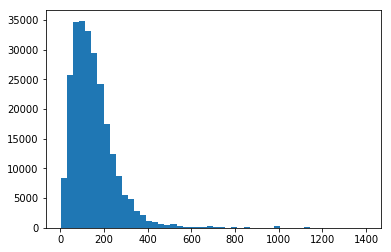

In [519]:
plt.hist([len(df_ontonotes_train.loc[i].sentence) for i in df_ontonotes_train.index], bins=50)
plt.show()

In [520]:
l_sent=[len(df_ontonotes_train.loc[i].sentence) for i in df_ontonotes_train.index]

In [523]:
max(l_sent)

1396

In [ ]:
#maximum length of the named entity


In [663]:
def truncate_sentence(st,start,end,c=10):
    s=st.split(' ')
    start+=1
    end+=1
    nst=[]
    if (start-c<=0) and (end+c<len(s)):
        nst=s[0:end+c]

    elif (start-c<=0) and (end+c>=len(s)):
        nst=s[0:len(s)]

    elif (start-c>0) and (end+c<len(s)):
        nst=s[start-c:end+c]
    else :
        nst=s[start-c:len(s)]
        
    return nst

In [667]:
st='predicting only classes at the leaf nodes. his approach behaves like a traditional classification algorithm. However, this very simple approach has the serious disadvantage of having to build a '

truncate_sentence(st,10,14,1)

['like', 'a', 'traditional', 'classification', 'algorithm.', 'However,']

# converting the data

In [792]:
df=df_ontonotes_train.sort_values(by='sentence')

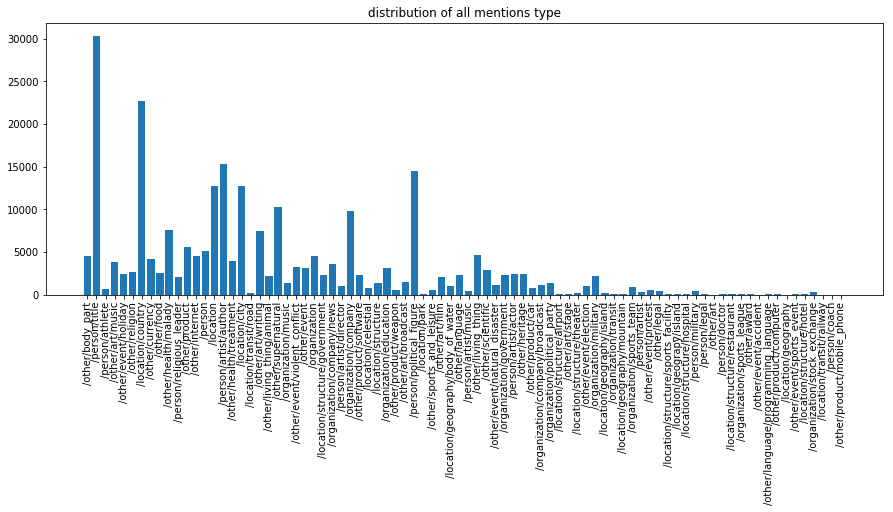

In [795]:
lst=[]
for i in df_ontonotes_train.index:
    lst+=df_ontonotes_train.one_mention[i]
diff_mentions_cl=set( lst)
occ_mentions_cl=Counter(lst)
occ_mentions_cl=dict(occ_mentions_cl)
plot_distribution(occ_mentions_cl,'all')

In [1064]:
len(set(occ_mentions_cl_t))

64

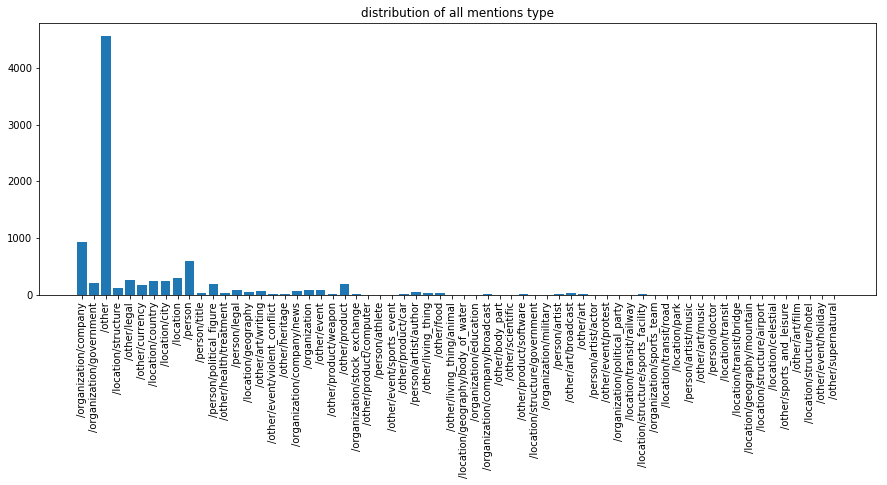

In [796]:
lst=[]
for i in df_ontonotes_test.index:
    lst+=df_ontonotes_test.one_mention[i]
diff_mentions_cl_t=set( lst)
occ_mentions_cl_t=Counter(lst)
occ_mentions_cl_t=dict(occ_mentions_cl_t)
plot_distribution(occ_mentions_cl_t,'all')

In [1089]:
#the test and the validation data doesn't have the same distribution as training data 
#and most of the tags are just one level that's i try to split the training data into train/test/dev 
#i keep 0.6 for training, 0.2 for test, 0.2 for dev
def convert(new_data):
    tokens_ls=[]
    sent_id_ls=[]
    tags_ls=[]
    for l in range(len(new_data)):   
        if l%100==0:
            print(l)
        tokens=word_tokenize(new_data[l][0])
        tags=['O' for i in range(len(tokens))]
        for i in range(len(tags)):
            for j in range(1,len(new_data[l])):
                tags[new_data[l][j][0][0]]='B-'+new_data[l][j][1][0]
                if new_data[l][j][0][1]<len(tokens):
                    end=new_data[l][j][0][1]
                else :
                    end=len(tokens)
                for k in range(new_data[l][j][0][0]+1,end):

                    tags[k]='I-'+new_data[l][j][1][0]
        sent_id=[l for i in range(len(tokens))]     
        tokens_ls+=tokens
        tags_ls+=tags
        sent_id_ls+=sent_id
        sent_id+=' '
        tags_ls+=' '
        tokens_ls+=' '
    zippedList =  list(zip(sent_id_ls, tokens_ls, tags_ls))
    dfObj = pd.DataFrame(zippedList, columns = ['sentence_id' , 'token', 'tag']) 
    return dfObj

def convert_data_to_connl_with_splitting_data(df):    
    
    df=df.sort_values(by='sentence')
    new_data=[]
    idx=df.index
    line=df.loc[idx[0]]
    row=[line.sentence,[(line.start,line.end),line.one_mention]]
    for i in idx[1:len(idx)]:
        line2=df.loc[i]
        if line.sentence==line2.sentence:
            row.append([(line2.start,line2.end),line2.one_mention])
        else : 
            line=df.loc[i]
            new_data.append(row)
            row=[line.sentence,[(line.start,line.end),line.one_mention]]
    new_data.append(row)    
    
    X_train, X_test = train_test_split(new_data, test_size=0.4)
    X_test, X_dev = train_test_split(X_test, test_size=0.33)
    train=convert(X_train)
    test=convert(X_test)
    dev=convert(X_dev)
    
    
    return train,test,dev

In [1134]:
def convert_data(df):    
    
    df=df.sort_values(by='sentence')
    new_data=[]
    idx=df.index
    line=df.loc[idx[0]]
    row=[line.sentence,[(line.start,line.end),line.one_mention]]
    for i in idx[1:len(idx)]:
        line2=df.loc[i]
        if line.sentence==line2.sentence:
            row.append([(line2.start,line2.end),line2.one_mention])
        else : 
            line=df.loc[i]
            new_data.append(row)
            row=[line.sentence,[(line.start,line.end),line.one_mention]]
    new_data.append(row) 
    return new_data

In [1090]:
def convert_data_to_connl(df):    
    
    df=df.sort_values(by='sentence')
    new_data=[]
    idx=df.index
    line=df.loc[idx[0]]
    row=[line.sentence,[(line.start,line.end),line.one_mention]]
    for i in idx[1:len(idx)]:
        line2=df.loc[i]
        if line.sentence==line2.sentence:
            row.append([(line2.start,line2.end),line2.one_mention])
        else : 
            line=df.loc[i]
            new_data.append(row)
            row=[line.sentence,[(line.start,line.end),line.one_mention]]
    new_data.append(row)    
    
    tokens_ls=[]
    sent_id_ls=[]
    tags_ls=[]
    for l in range(len(new_data)):   
        if l%100==0:
            print(l)
        tokens=word_tokenize(new_data[l][0])
        tags=['O' for i in range(len(tokens))]
        for i in range(len(tags)):
            for j in range(1,len(new_data[l])):
                tags[new_data[l][j][0][0]]='B-'+new_data[l][j][1][0]
                if new_data[l][j][0][1]<len(tokens):
                    end=new_data[l][j][0][1]
                else :
                    end=len(tokens)
                for k in range(new_data[l][j][0][0]+1,end):

                    tags[k]='I-'+new_data[l][j][1][0]
        sent_id=[l for i in range(len(tokens))]     
        tokens_ls+=tokens
        tags_ls+=tags
        sent_id_ls+=sent_id
        sent_id+=' '
        tags_ls+=' '
        tokens_ls+=' '
    zippedList =  list(zip(sent_id_ls, tokens_ls, tags_ls))
    dfObj = pd.DataFrame(zippedList, columns = ['sentence_id' , 'token', 'tag']) 
    return dfObj

In [1082]:
new_data[2]

['$ 10 billion of three-year notes , to be auctioned Tuesday and to mature Nov. 15 , 1992 .',
 [(10, 11), ['/other/event/holiday']]]

In [1050]:
cnLL_df_ontonotes_train=convert_data_to_connl(df_ontonotes_train)
cnLL_df_ontonotes_test=convert_data_to_connl(df_ontonotes_test)
cnLL_df_ontonotes_dev=convert_data_to_connl(df_ontonotes_dev)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [1091]:
cnLL_df_ontonotes_train_,cnLL_df_ontonotes_test_,cnLL_df_ontonotes_dev_=convert_data_to_connl_with_splitting_data(df_ontonotes_train)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [1155]:
cnLL_df_ontonotes_train_

,sentence_id,token,tag
0,0,Tamar,B-/person
1,0,tore,B-/other/health/malady
2,0,her,O
3,0,robe,B-/other/product
4,0,of,O
5,0,many,O
6,0,colors,O
7,0,and,O
8,0,put,O
9,0,ashes,B-/location


In [1094]:
cnLL_df_ontonotes_train_[['token','tag']].to_csv('train_cnll_gen.txt', header=False,index=None,sep='\t')
cnLL_df_ontonotes_test_[['token','tag']].to_csv('test_cnll_gen.txt', header=False,index=None,sep='\t')
cnLL_df_ontonotes_dev_[['token','tag']].to_csv('dev_cnll_gen.txt', header=False,index=None,sep='\t')

In [ ]:
cnLL_df_ontonotes_train[['token','tag']].to_csv('train_cnll.txt', header=False,index=None,sep='\t')
cnLL_df_ontonotes_test[['token','tag']].to_csv('test_cnll.txt', header=False,index=None,sep='\t')
cnLL_df_ontonotes_dev[['token','tag']].to_csv('dev_cnll.txt', header=False,index=None,sep='\t')

In [1053]:
cnLL_df_ontonotes_train=pd.read_hdf('cnLL_df_ontonotes_train.hdf')
cnLL_df_ontonotes_test=pd.read_hdf('cnLL_df_ontonotes_test.hdf')
cnLL_df_ontonotes_dev=pd.read_hdf('cnLL_df_ontonotes_dev.hdf')

In [1163]:
cnLL_df_ontonotes_train

,sentence_id,token,tag,tag_level1
0,0,$,O,O
1,0,10,O,O
2,0,billion,O,O
3,0,of,O,O
4,0,10-year,O,O
5,0,notes,O,O
6,0,",",O,O
7,0,to,O,O
8,0,be,O,O
9,0,auctioned,O,O


In [1054]:
def get_tag_level1(x):
    if x=='O':
        return 'O'
    else :
        return x[0:2]+x.split('/')[1]

In [1055]:
cnLL_df_ontonotes_train['tag_level1']=cnLL_df_ontonotes_train.tag.apply(get_tag_level1)
cnLL_df_ontonotes_test['tag_level1']=cnLL_df_ontonotes_test.tag.apply(get_tag_level1)
cnLL_df_ontonotes_dev['tag_level1']=cnLL_df_ontonotes_dev.tag.apply(get_tag_level1)


In [1099]:
len(cnLL_df_ontonotes_train.token.unique())

65076

In [1154]:
set(cnLL_df_ontonotes_train.tag)

{'B-/location',
 'B-/location/celestial',
 'B-/location/city',
 'B-/location/country',
 'B-/location/geography',
 'B-/location/geography/body_of_water',
 'B-/location/geography/island',
 'B-/location/geography/mountain',
 'B-/location/geograpy/island',
 'B-/location/park',
 'B-/location/structure',
 'B-/location/structure/airport',
 'B-/location/structure/government',
 'B-/location/structure/hospital',
 'B-/location/structure/hotel',
 'B-/location/structure/restaurant',
 'B-/location/structure/sports_facility',
 'B-/location/structure/theater',
 'B-/location/transit/railway',
 'B-/location/transit/road',
 'B-/organization',
 'B-/organization/company',
 'B-/organization/company/broadcast',
 'B-/organization/company/news',
 'B-/organization/education',
 'B-/organization/government',
 'B-/organization/military',
 'B-/organization/music',
 'B-/organization/political_party',
 'B-/organization/sports_league',
 'B-/organization/sports_team',
 'B-/organization/stock_exchange',
 'B-/organizatio

# Model

### proposed idea:

**1. Flat Classification Approach:** is the simplest way to deal with hierarchical classification problems. it consists of ignoring the class hierarchy, typically predicting only classes at the leaf nodes.his approach behaves like a traditional classification algorithm. However, this very simple approach has the serious disadvantage of having to build a classifier to discriminate among a large number of classes, without exploring information about parent-child class relationships present in the class hierarchy.
<br> 
**2. Local Classifiers Approach:** The local classifier per level approach consists of training one multiclass classifier for each level of the class hierarchy. 

# working with the data without converting it to CoNLL format

In [753]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Concatenate, Flatten

In [ ]:
def truncate_sentence(st,start,end,c=10):
    s=st.split(' ')
    start+=1
    end+=1
    nst=[]
    if (start-c<=0) and (end+c<len(s)):
        nst=s[0:end+c]

    elif (start-c<=0) and (end+c>=len(s)):
        nst=s[0:len(s)]

    elif (start-c>0) and (end+c<len(s)):
        nst=s[start-c:end+c]
    else :
        nst=s[start-c:len(s)]
        
    return nst

In [674]:
#find the maximum number of token for a named entity
length=[df_ontonotes_train.loc[i].end-df_ontonotes_train.loc[i].start for i in df_ontonotes_train.index]


In [676]:
max(length)

6

In [ ]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx_level1 = {t: i for i, t in enumerate(typeDict_level1)}

In [755]:
#number of tags
def preprocess_data(df_data,maxlen=27,n_tags=4):
    sent = [truncate_sentence(df_data.loc[i].sentence,df_data.loc[i].start,df_data.loc[i].end,c=10) for i in df_data.index]
    mention = [truncate_sentence(df_data.loc[i].sentence,df_data.loc[i].start,df_data.loc[i].end,c=1) for i in df_data.index]
    named_entity = list(df_data.entity)
    X_sent = [[word2idx[w[0]] for w in s] for s in sent]
    X_mention = [[word2idx[w[0]] for w in s] for s in mention]
    X_named_entity = [word2idx[s] for s in named_entity]
    X_sent = pad_sequences(maxlen=maxlen, sequences= X_sent, padding="post",value=n_words - 1)
    X_mention = pad_sequences(maxlen=maxlen, sequences= X_mention, padding="post",value=n_words - 1)
    X_named_entity = pad_sequences(maxlen=maxlen, sequences= X_named_entity, padding="post",value=n_words - 1)
    Y_mention_type_level1 = list(df_data.one_mention.apply(lambda x : x[0].split('/')[1]))
    Y_mention_type_level1 = [tag2idx[s] for s in Y_mention_type_level1]
    Y_mention_type_level1 = [to_categorical(i, num_classes=n_tags) for i in Y_mention_type_level1]
    
    return X_sent,X_mention,X_named_entity, Y_mention_type_level1
    

In [ ]:
X_sent_train,X_mention_train,X_named_entity_train, Y_mention_type_level1_train=preprocess_data(df_ontonotes_train)
X_sent_test,X_mention_test,X_named_entity_test, Y_mention_type_level1_test=preprocess_data(df_ontonotes_test)
X_sent_dev,X_mention_dev,X_named_entity_dev, Y_mention_type_level1_dev=preprocess_data(df_ontonotes_dev)

In [720]:
#build 5 model
#for the root and then for each one [person, other, location, organization]

#this model for the root to predict whether it is a person, organization, other or location
#context representation
inputa = Input(shape=(27,), name='input1')
inputb = Input(shape=(8,), name = 'input2')
inputc = Input(shape=(6,), name = 'input3')

X = Embedding(input_dim=n_words, output_dim=27, input_length=27)(inputa)
X = Dropout(0.1)(X)
X = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(X)
X = Flatten()(X)
X = Model(inputs=inputa, outputs=X)
                                                                 
#mention representation

Y = Embedding(input_dim=n_words, output_dim=8, input_length=8)(inputb)
Y = Dropout(0.1)(Y)
Y = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(Y)
Y = Flatten()(Y)
Y = Model(inputs=inputb, outputs=Y)
# mention embedding

Z = Embedding(input_dim=n_words, output_dim=6, input_length=6)(inputc)
Z = Flatten()(Z)
Z = Model(inputs=inputc, outputs=Z)

# combine the output of the three branches
combined = Concatenate(axis=-1)([X.output, Y.output, Z.output])


out =  Dense(4, activation="softmax")(combined)

model = Model(inputs=[inputa, inputb, inputc ], outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 27)           0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 8)            0                                            
__________________________________________________________________________________________________
embedding_54 (Embedding)        (None, 27, 27)       1757106     input1[0][0]                     
__________________________________________________________________________________________________
embedding_55 (Embedding)        (None, 8, 8)         520624      input2[0][0]                     
__________________________________________________________________________________________________
dropout_44

In [722]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
